# Turtle strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from copy import deepcopy, copy

/Users/julesderichemont/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
def calcTR(high, low, close):
    '''Calculate True Range'''
    return np.max(np.abs([high-low, close-low, low-close]))

def getStratStats(log_returns: pd.Series, risk_free_rate: float = 0.02):
    stats = {} # Total Returns
    stats['tot_returns'] = np.exp(log_returns.sum()) - 1
    # Mean Annual Returns
    stats['annual_returns'] = np.exp(log_returns.mean() * 252) - 1
    # Annual Volatility
    stats['annual_volatility'] = log_returns.std() * np.sqrt(252)
    # Sortino Ratio
    annualized_downside = log_returns.loc[log_returns<0].std() * np.sqrt(252)
    stats['sortino_ratio'] = (stats['annual_returns'] - risk_free_rate) / annualized_downside
    # Sharpe Ratio
    stats['sharpe_ratio'] = (stats['annual_returns'] - risk_free_rate) / stats['annual_volatility']
    # Max Drawdown
    cum_returns = log_returns.cumsum() - 1
    peak = cum_returns.cummax()
    drawdown = peak - cum_returns
    max_idx = drawdown.argmax()
    stats['max_drawdown'] = 1 - np.exp(cum_returns[max_idx]) / np.exp(peak[max_idx])
    # Max Drawdown Duration
    strat_dd = drawdown[drawdown==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days,(drawdown.index[-1] - strat_dd.index[-1]).days])
    stats['max_drawdown_duration'] = strat_dd_days.max()
    return {k: np.round(v, 4) if type(v) == np.float_ else v for k, v in stats.items()}

In [37]:
class TurtleSystem:
    def __init__(self, tickers, init_account_size=10000, risk_level=2, r_max=0.02, sys1_entry=20, sys1_exit=10, 
                 sys2_entry=55, sys2_exit=20, atr_periods=20, sys1_allocation=0.5, risk_reduction_rate=0.1,
                 risk_reduction_level=0.2, unit_limit=5, pyramid_units=1,start='2000-01-01', end='2020-12-31', shorts=True):
        '''
        tickers: list of security symbols to trade.
        init_account_size: int that sets initial trading capital
        risk_level: float used to determine the stop loss distance by multiplying this value with N.
        r_max: float max percentage of account that a trade can risk.
        sys1_entry: int determines number of breakout days for System 1 to generate a buy signal.
        sys1_exit: int determines number of breakout days for System 1 to generate a sell signal.
        sys2_entry: int determines number of breakout days for System 2 to generate a buy signal.
        sys2_exit: int determines number of breakout days for System 2 to generate a sell signal.
        sys1_allocation: float to balance capital allocation between System 1 and 2.
        start: str first date for getting data.
        end: str end date for getting data.
        shorts: bool to allow short positions if True.
        atr_periods: int number of days used to calculate SMA of N.
        risk_reduction_rate: float < 1 represents the amount of loss the system sees before it reduces its trading size.
        risk_reduction_level: float < 1 represents each increment in risk the the system reduces as it loses capital below its initial size.
        '''
        self.tickers = tickers
        self.init_account_size = init_account_size
        self.cash = init_account_size
        self.portfolio_value = init_account_size
        self.risk_level = risk_level
        self.r_max = r_max
        self.sys1_entry = sys1_entry
        self.sys1_exit = sys1_exit
        self.sys2_entry = sys2_entry
        self.sys2_exit = sys2_exit
        self.sys1_allocation = sys1_allocation
        self.sys2_allocation = 1 - sys1_allocation
        self.start = start
        self.end = end
        self.atr_periods = atr_periods
        self.shorts = shorts
        self.last_s1_win = {t: False for t in self.tickers}
        self.unit_limit = unit_limit
        self.risk_reduction_level = risk_reduction_level
        self.risk_reduction_rate = risk_reduction_rate
        self.pyramid_units = pyramid_units
        self.sys_list = ['S1', 'S2']
        self._prep_data()

    def _prep_data(self):
        self.data = self._get_data()
        self._calc_breakouts()
        self._calc_N()
    
    def _get_data(self):
        # Gets data for all tickers from YFinance
        yfObj = yf.Tickers(self.tickers)
        df = yfObj.history(start=self.start, end=self.end)
        df.drop(['Open', 'Dividends', 'Stock Splits', 'Volume'],inplace=True, axis=1)
        df.ffill(inplace=True)
        return df.swaplevel(axis=1)
    
    def _calc_breakouts(self):
        # Gets breakouts for all tickers
        new_data = pd.DataFrame(index=self.data.index)  # Create a new DataFrame with the same index

        for t in self.tickers:
            # Breakouts for enter long position (EL), exit long (ExL), enter short (ES), exit short (ExS)
            new_data[t, 'S1_EL'] = self.data[t]['Close'].rolling(self.sys1_entry).max()
            new_data[t, 'S1_ExL'] = self.data[t]['Close'].rolling(self.sys1_exit).min()
            new_data[t, 'S2_EL'] = self.data[t]['Close'].rolling(self.sys2_entry).max()
            new_data[t, 'S2_ExL'] = self.data[t]['Close'].rolling(self.sys2_exit).min()

            if self.shorts:
                new_data[t, 'S1_ES'] = self.data[t]['Close'].rolling(self.sys1_entry).min()
                new_data[t, 'S1_ExS'] = self.data[t]['Close'].rolling(self.sys1_exit).max()
                new_data[t, 'S2_ES'] = self.data[t]['Close'].rolling(self.sys2_entry).min()
                new_data[t, 'S2_ExS'] = self.data[t]['Close'].rolling(self.sys2_exit).max()

        # Concatenate the new columns to the existing DataFrame
        self.data = pd.concat([self.data, new_data], join='outer', axis=1)

    
    def _calc_N(self):
        # Calculates N for all tickers
        new_data = pd.DataFrame(index=self.data.index)  # Create a new DataFrame with the same index
        for t in self.tickers:
            tr = self.data[t].apply(lambda x: calcTR(x['High'], x['Low'], x['Close']), axis=1)
            new_data[t, 'N'] = tr.rolling(self.atr_periods).mean()
        # Concatenate the new columns to the existing DataFrame
        self.data = pd.concat([self.data, new_data], axis=1)

    
    def _check_cash_balance(self, shares, price):
        # Checks to see if we have enough cash to make purchase. If not, resizes position to lowest feasible level
        if self.cash <= shares * price:
            shares = np.floor(self.cash / price)
        return shares
    
    def _adjust_risk_units(self, units):
        # Scales units down by 20% for every 10% of capital that has been lost under default settings.
        cap_loss = 1 - self.portfolio_value / self.init_account_size
        if cap_loss > self.risk_reduction_level:
            scale = np.floor(cap_loss / self.risk_reduction_level)
            units *= (1 - scale * self.risk_reduction_rate)
        return units
    
    def _calc_portfolio_value(self, portfolio):
        pv = sum([v1['value'] for v0 in portfolio.values() if type(v0) is dict 
                  for k1, v1 in v0.items() if v1 is not None])
        pv += self.cash
        if np.isnan(pv):
            raise ValueError(f"PV = {pv}\n{portfolio}")
        return pv

    def _get_units(self, system):
        sys_all = self.sys1_allocation if system == 1 else self.sys2_allocation
        dollar_units = self.r_max * self.portfolio_value * sys_all
        dollar_units = self._adjust_risk_units(dollar_units)
        return dollar_units

    def _size_position(self, data, dollar_units):
        shares = np.floor(dollar_units / (self.risk_level * data['N'] * data['Close']))
        return shares

    def _run_system(self, ticker, data, position, system=1):
        S = system # System number
        price = data['Close']
        if np.isnan(price):
            # Return current position in case of missing data
            return position
        N = data['N']
        dollar_units = self._get_units(S)
        shares = 0
        if position is None:
            if price == data[f'S{S}_EL']: # Buy on breakout
                if S == 1 and self.last_s1_win[ticker]:
                    self.last_s1_win[ticker] = False
                    return None
                shares = self._size_position(data, dollar_units)
                stop_price = price - self.risk_level * N
                long = True
            elif self.shorts:
                if price == data[f'S{S}_ES']: # Sell short
                    if S == 1 and self.last_s1_win[ticker]:
                        self.last_s1_win[ticker] = False
                        return None
                    shares = self._size_position(data, dollar_units)
                    stop_price = price + self.risk_level * N
                    long = False
            else:
                return None
            if shares == 0:
                return None
                # Ensure we have enough cash to trade
            shares = self._check_cash_balance(shares, price)
            value = price * shares
            self.cash -= value
            position = {'units': 1,'shares': shares,'entry_price': price,'stop_price': stop_price,
                        'entry_N': N,'value': value,'long': long}
            if np.isnan(self.cash) or self.cash < 0:
                raise ValueError(f"Cash Error\n{S}-{ticker}\n{data}\n{position}")

        else:
            if position['long']:
            # Check to exit existing long position
                if price == data[f'S{S}_ExL'] or price <= position['stop_price']:
                    self.cash += position['shares'] * price
                    if price >= position['entry_price']:
                        self.last_s1_win[ticker] = True
                    else:
                        self.last_s1_win[ticker] = False
                    position = None
                # Check to pyramid existing position
                elif position['units'] < self.unit_limit:
                    if price >= position['entry_price'] + position['entry_N']:
                        shares = self._size_position(data, dollar_units)
                        shares = self._check_cash_balance(shares, price)
                        self.cash -= shares * price
                        stop_price = price - self.risk_level * N
                        avg_price = (position['entry_price']*position['shares']+shares*price)/(position['shares']+shares)
                        position['entry_price'] = avg_price
                        position['shares'] += shares
                        position['stop_price'] = stop_price
                        position['units'] += 1
            else:
                # Check to exit existing short position
                if price == data[f'S{S}_ExS'] or price >= position['stop_price']:
                    self.cash += position['shares'] * price
                    if S == 1:
                        if price <= position['entry_price']:
                            self.last_s1_win[ticker] = True
                        else:
                            self.last_s1_win[ticker] = False
                    position = None
                # Check to pyramid existing position
                elif position['units'] < self.unit_limit:
                    if price <= position['entry_price'] - position['entry_N']:
                        shares = self._size_position(data, dollar_units)
                        shares = self._check_cash_balance(shares, price)
                        self.cash -= shares * price
                        stop_price = price + self.risk_level * N
                        avg_price = (position['entry_price']*position['shares']+shares*price)/(position['shares']+shares)
                        position['entry_price'] = avg_price
                        position['shares'] += shares
                        position['stop_price'] = stop_price
                        position['units'] += 1
            if position is not None:
                # Update value at each time step
                position['value'] = position['shares'] * price
        
        return position

    def run(self):
        # Runs backtest on the turtle strategy
        self.portfolio = {}
        position = {s: {t: None for t in self.tickers} for s in self.sys_list}
        for i, (ts, row) in enumerate(self.data.iterrows()):
            for t in self.tickers:
                for s, system in enumerate(self.sys_list):
                    position[system][t] = self._run_system(t, row[t], position[system][t])
                self.portfolio[i] = deepcopy(position)
                self.portfolio[i]['date'] = ts
                self.portfolio[i]['cash'] = copy(self.cash)
                self.portfolio_value = self._calc_portfolio_value(self.portfolio[i])
    
    def get_portfolio_values(self):
        vals = []
        for v in self.portfolio.values():
            pv = sum([v1['value'] for v0 in v.values() if type(v0) is dict for k1, v1 in v0.items() if v1 is not None])
            pv += v['cash']
            vals.append(pv)
        return pd.Series(vals, index=self.data.index)

    def get_system_data_dict(self):
        sys_dict = {}
        cols = ['units', 'shares', 'entry_price', 'stop_price','entry_N', 'value', 'long']
        X = np.empty(shape=(len(cols)))
        X[:] = np.nan
        index = [v['date'] for v in self.portfolio.values()]
        for s in self.sys_list:
            for t in self.tickers:
                df = pd.DataFrame()
                for i, v in enumerate(self.portfolio.values()):
                    d = v[s][t]
                    if d is None:
                        if i == 0:
                            _array = X.copy()
                        else:
                            _array = np.vstack([_array, X])
                    else:
                        vals = np.array([float(d[i]) for i in cols])
                        if i == 0:
                            _array = vals.copy()
                        else:
                            _array = np.vstack([_array, vals])
                df = pd.DataFrame(_array, columns=cols, index=index)
                sys_dict[(s, t)] = df.copy()
        return sys_dict

    def get_transactions(self):
        ddict = self.get_system_data_dict()
        transactions = pd.DataFrame()
        for k, v in ddict.items():
            df = pd.concat([v, self.data[k[1]].copy()], axis=1)
            df.fillna(0, inplace=True)
            rets = df['Close'] / df['entry_price'].shift(1) -1
            trans = pd.DataFrame(rets[df['shares'].diff()<0],
            columns=['Returns'])
            trans['System'] = k[0]
            trans['Ticker'] = k[1]
            trans['Long'] = df['long'].shift(1).loc[df['shares'].diff()<0]
            trans['Units'] = df['units'].shift(1).loc[df['shares'].diff()<0]
            trans['Entry_Price'] = df['entry_price'].shift(1).loc[
            df['shares'].diff()<0]
            trans['Sell_Price'] = df['Close'].loc[df['shares'].diff()<0]
            trans['Shares'] = df['shares'].shift(1).loc[df['shares'].diff()<0]
            trans.reset_index(inplace=True)
            trans.rename(columns={'index': 'Date'}, inplace=True)
            transactions = pd.concat([transactions, trans.copy()])
        transactions.reset_index(inplace=True)
        transactions.drop('index', axis=1, inplace=True)
        return transactions

In [35]:
# Sample AMOUNT tickers from S&P 500
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(url)
df = table[0]
syms = df['Symbol']

# Sample symbols
AMOUNT = 50
tickers = list(np.random.choice(syms.values, size=AMOUNT))
print("Ticker Symbols:")
_ = [print(f"\t{i}") for i in tickers]
sys = TurtleSystem(tickers, init_account_size=1E4, start='2001-10-24') #2000-01-01
sys.run()

Ticker Symbols:
	VICI
	TMO
	ORCL
	SNPS
	KR
	AME
	FAST
	BLK
	FI
	WST
	ADI
	DLTR
	HAS
	BBY
	ES
	ADI
	MU
	TXT
	UHS
	SJM
	FFIV
	CSX
	URI
	COP
	ADBE
	HUM
	ULTA
	L
	DUK
	PPG
	GOOG
	DIS
	IR
	CMI
	RL
	ANET
	RMD
	SWKS
	AZO
	RVTY
	LIN
	PH
	MTB
	T
	K
	EVRG
	MSCI
	LLY
	DVN
	EQIX
[*********************100%%**********************]  49 of 49 completed


<ipython-input-34-de89e413e9bb>:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[t, 'S1_ES'] = self.data[t]['Close'].rolling(self.sys1_entry).min()
<ipython-input-34-de89e413e9bb>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[t, 'S1_ExS'] = self.data[t]['Close'].rolling(self.sys1_exit).max()
<ipython-input-34-de89e413e9bb>:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

<ipython-input-34-de89e413e9bb>:177: RuntimeWarning: invalid value encountered in scalar divide
  avg_price = (position['entry_price'] * position['shares'] +
<ipython-input-34-de89e413e9bb>:200: RuntimeWarning: invalid value encountered in scalar divide
  avg_price = (position['entry_price']*position['shares']+shares*price)/(position['shares']+shares)


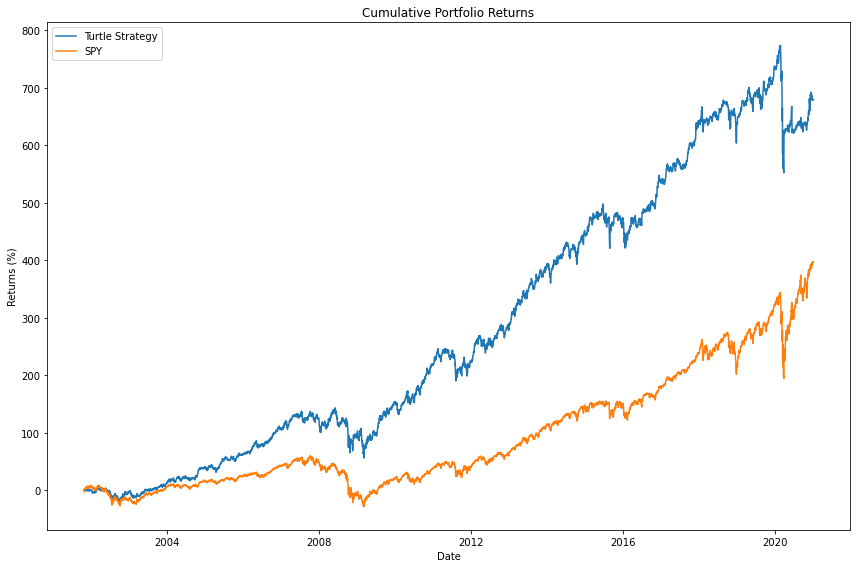

,tot_returns,annual_returns,annual_volatility,sortino_ratio,sharpe_ratio,max_drawdown,max_drawdown_duration
Turtle,6.7892,0.1131,0.1576,0.7502,0.5905,0.3577,530
SPY,3.9757,0.0873,0.1955,0.4130,0.3445,0.5519,1773


In [36]:
port_values = sys.get_portfolio_values()
returns = port_values / port_values.shift(1)
log_returns = np.log(returns)
cum_rets = log_returns.cumsum()
# Compare to SPY baseline
sp500 = yf.Ticker('SPY').history(start=sys.start, end=sys.end)
sp500['returns'] = sp500['Close'] / sp500['Close'].shift(1)
sp500['log_returns'] = np.log(sp500['returns'])
sp500['cum_rets'] = sp500['log_returns'].cumsum()

plt.figure(figsize=(12, 8))
plt.plot((np.exp(cum_rets) -1 )* 100, label='Turtle Strategy')
plt.plot((np.exp(sp500['cum_rets']) - 1) * 100, label='SPY')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.title('Cumulative Portfolio Returns')
plt.legend()
plt.tight_layout()
plt.show()

stats = getStratStats(log_returns)
spy_stats = getStratStats(sp500['log_returns'])
df_stats = pd.DataFrame(stats, index=['Turtle'])
df_stats = pd.concat([df_stats, pd.DataFrame(spy_stats, index=['SPY'])])
df_stats

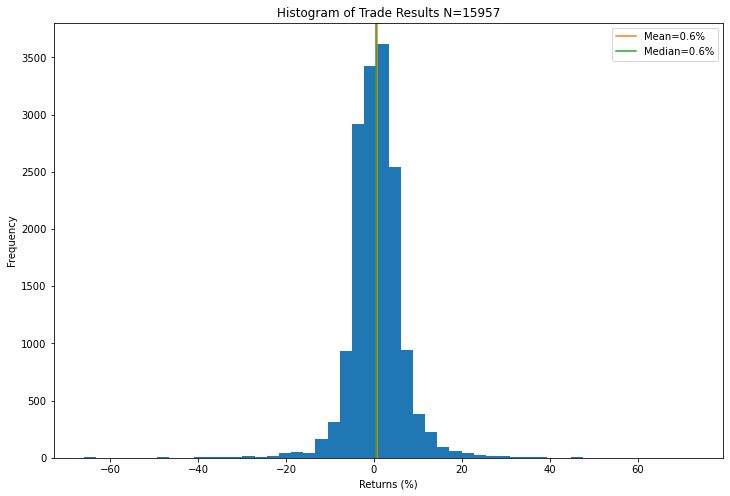

In [38]:
transactions = sys.get_transactions()
mean = transactions['Returns'].mean() * 100
median = np.median(transactions['Returns']) * 100
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(12, 8))
plt.hist(transactions['Returns']*100, bins=50)
plt.axvline(mean, c=colors[1], label=f'Mean={mean:.1f}%')
plt.axvline(median, c=colors[2], label=f'Median={median:.1f}%')
plt.ylabel('Frequency')
plt.xlabel('Returns (%)')
plt.title(f'Histogram of Trade Results N={len(transactions)}')
plt.legend()
plt.show()

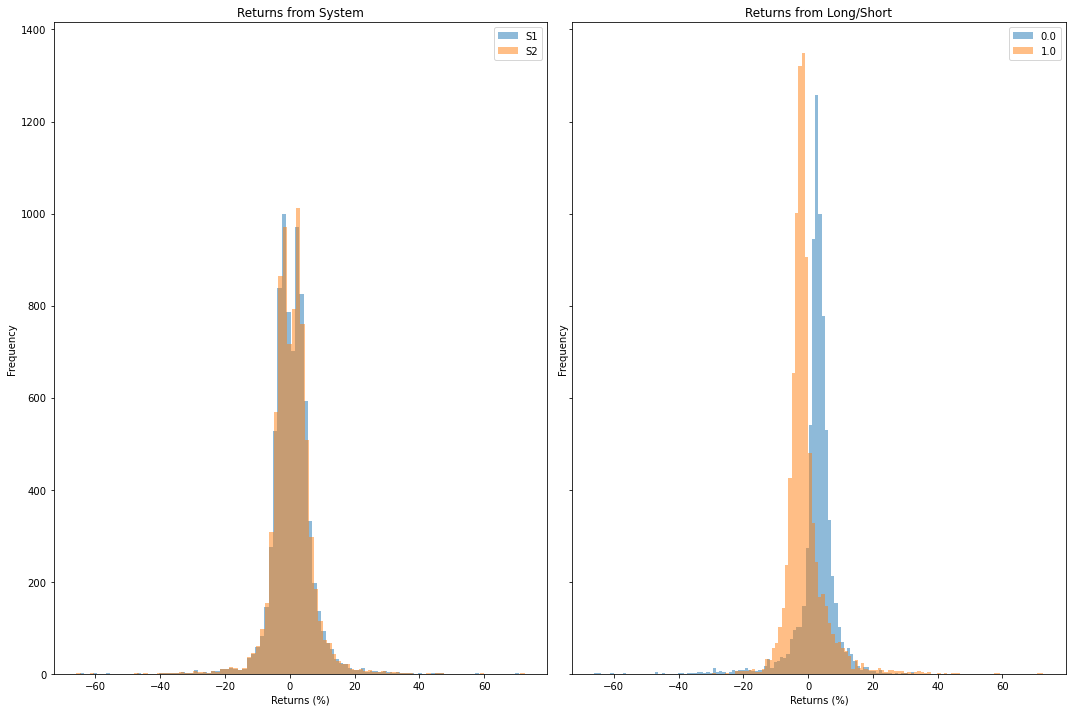

In [39]:
category = ['System', 'Long']
fig, ax = plt.subplots(1, len(category), figsize=(15, 10), sharey=True)
for i, c in enumerate(category):
    vals = transactions[c].unique()
    for v in vals:
        data = transactions.loc[transactions[c]==v]
        ax[i].hist(data['Returns'] * 100, label=v, alpha=0.5, bins=100)
        ax[i].set_ylabel('Frequency') 
    ax[i].set_xlabel('Returns (%)')
    ax[i].legend()
ax[0].set_title('Returns from System')
ax[1].set_title('Returns from Long/Short')
plt.tight_layout()
plt.show()

In [40]:
from scipy.stats import skew
transactions.groupby(['Ticker'])['Returns'].agg({'count', 'mean', 'median', 'std', 'skew'})

,median,mean,count,skew,std
Ticker,,,,,
ADBE,0.001762,0.006353,325,0.520404,0.064819
ADI,0.012037,0.005365,405,0.040943,0.051095
AME,0.001297,0.004621,441,0.462245,0.044434
ANET,-0.006731,0.001145,151,-0.228652,0.075272
BBY,0.009131,0.004246,400,-0.348962,0.078200
BLK,-0.011972,0.002092,77,0.716903,0.037335
CMI,0.017404,0.015328,310,-2.868785,0.078753
COP,0.001097,0.003233,363,-1.918445,0.067316
CSX,0.008966,0.006025,410,-0.046639,0.051151
